# **YOLO Real-Time Object Detection**

# 1. Initial Setup

In [1]:
!pip install ultralytics

In [2]:
import ultralytics
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
import torch

print(f"Ultralytics version: {ultralytics.__version__}")
print(f"Using GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU (Slow)'}")

Ultralytics version: 8.4.8
Using GPU: Tesla T4


## 2. Premade Model Use: Image

In [3]:
# 1. Load the premade YOLO model
# Using the 'n' model (smallest)
model = YOLO('yolov8n.pt')

# 2. Run inference on sample image
results = model.predict(source='https://ultralytics.com/images/bus.jpg', save=True, conf=0.5)


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 640x480 3 persons, 1 bus, 77.4ms
Speed: 7.0ms preprocess, 77.4ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict2


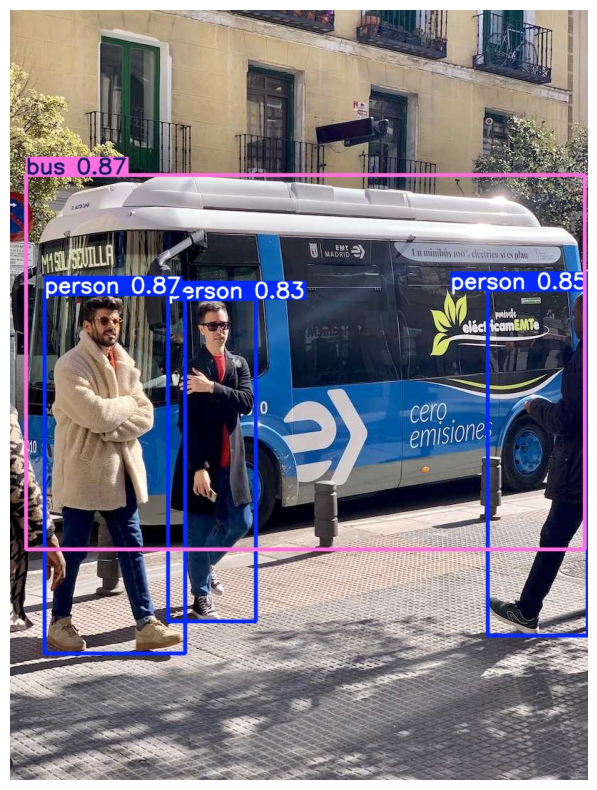

In [4]:
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get the results
latest_folder = max(glob.glob('runs/detect/predict*'), key=os.path.getmtime)
image_path = os.path.join(latest_folder, 'bus.jpg')

# Visualize results
img = mpimg.imread(image_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

## 3. Premade Model Use: Video

In [5]:
# Check the classes in the model first
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [6]:
import os
import sys

# 1. Check if video exists and has data
file_path = 'input_video.mp4'
if os.path.exists(file_path):
    size = os.path.getsize(file_path)
    print(f"Video found. Size: {size / 1024 / 1024:.2f} MB")
    if size < 1000: # Less than 1KB
        print("ERROR: Video file is empty or corrupt. Re-downloading...")
        !rm input_video.mp4
        !wget -O input_video.mp4 https://github.com/intel-iot-devkit/sample-videos/raw/master/people-detection.mp4
else:
    print("Video not found! Downloading now...")
    !wget -O input_video.mp4 https://github.com/intel-iot-devkit/sample-videos/raw/master/people-detection.mp4

# 2. Run model
print("Loading model...")
results = model.predict(source='input_video.mp4', stream=True, conf=0.5, verbose=False)

print("Starting loop")
frame_count = 0

# 3. Iterate
for result in results:
    frame_count += 1

    # Simple count check
    # We use sys.stdout.flush() to FORCE Colab to print immediately
    if frame_count % 5 == 0:
        print(f"Processing Frame {frame_count}...", end='\r')
        sys.stdout.flush()

print(f"\nSuccess! Processed {frame_count} frames.")

Video found. Size: 5.23 MB
Loading model...
Starting loop

Success! Processed 596 frames.


## 4. Custom Model: Red Balls

1.   This model will be to test model customization. We will start with red balls and add more colors.
2.   The training data will use a syntethic dataset that will be made here.
3.   The image and label data will be generated before being used for training.

### 4.1 Initial Setup

In [7]:
import cv2
import numpy as np
import os
import random
import yaml

In [8]:
# Setup folders
base_dir = 'datasets/syntethic_balls'
if os.path.exists(base_dir):
  import shutil
  shutil.rmtree(base_dir) # Make sure its empty

os.makedirs(f'{base_dir}/train/images', exist_ok=True)
os.makedirs(f'{base_dir}/train/labels', exist_ok=True)
os.makedirs(f'{base_dir}/test/images', exist_ok=True)
os.makedirs(f'{base_dir}/test/labels', exist_ok=True)

In [9]:
# Ball generating function
def create_dataset(subset, count=50):
  print(f"Generating {count} images for {subset}...")

  for i in range(count):
    # Create black canvas for background
    img_size = 640
    img = np.zeros((img_size, img_size, 3), dtype=np.uint8)

    # Create random balls/circles
    # Random radius between 20-100px
    radius = random.randint(20,100)

    # Calculate center of circle
    # Make sure it stays in the image
    center_x = random.randint(radius, img_size - radius)
    center_y = random.randint(radius, img_size - radius)

    # Draw RED circle
    cv2.circle(img, (center_x, center_y), radius, (0,0,255), -1)

    # Save the image
    img_filename = f'{base_dir}/{subset}/images/ball_{i}.jpg'
    cv2.imwrite(img_filename, img)

    # Calculate YOLO label
    # Format: class_id x_center y_center width height
    # Class ID 0 = "Red Ball"
    norm_x = center_x / img_size
    norm_y = center_y / img_size
    norm_w = (radius * 2) / img_size
    norm_h = (radius * 2) / img_size

    # Save label
    lbl_filename = f'{base_dir}/{subset}/labels/ball_{i}.txt'
    with open(lbl_filename, 'w') as f:
      f.write(f"0 {norm_x:.6f} {norm_y:.6f} {norm_w:.6f} {norm_h:.6f}")

In [10]:
# Generate images
create_dataset('train', 50)
create_dataset('test', 10)

# Create YAML config file
data_yaml = {
    'path': os.path.abspath(base_dir),
    'train': 'train/images',
    'val': 'test/images',
    'names': {0: 'Red Ball'}
}

with open(f'{base_dir}/data.yaml', 'w') as f:
  yaml.dump(data_yaml, f)

print("Dataset created successfully!")
print(f"Config saved at: {base_dir}/data.yaml")

Generating 50 images for train...
Generating 10 images for test...
Dataset created successfully!
Config saved at: datasets/syntethic_balls/data.yaml


### 4.2 Model Training

In [15]:
# Use YOLO like before
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

# Train on synthetic data
print("Starting training on synthetic data")
model.train(data='datasets/syntethic_balls/data.yaml', epochs=50, imgsz=640)

Starting training on synthetic data
Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/syntethic_balls/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cdd661277a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

- Precision: 99.5%
- Recall: 100%
- mAP50: 99.5%
- mAP50-95: 99.4%

### 4.3 Prediction Test


image 1/1 /content/test_ball.jpg: 640x640 1 Red Ball, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict5


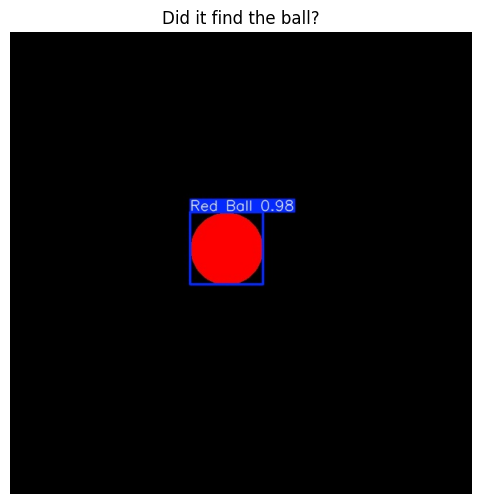

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Load the best model
latest_train = max(glob.glob('runs/detect/train*'), key=os.path.getmtime)
custom_model = YOLO(os.path.join(latest_train, 'weights', 'best.pt'))

# Generate a new ball image to test
test_img = np.zeros((640,640,3), dtype=np.uint8)
cv2.circle(test_img, (300,300), 50, (0,0,255), -1)
cv2.imwrite('test_ball.jpg', test_img)

# Predict
results = custom_model.predict('test_ball.jpg', save=True, conf=0.2)

# Show predictions
latest_predict = max(glob.glob('runs/detect/predict*'), key=os.path.getmtime)
result_path = os.path.join(latest_predict, 'test_ball.jpg')

img = mpimg.imread(result_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Did it find the ball?")
plt.show()